In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchinfo
import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Resize, Lambda

import numpy as np
import math

from typing import TypedDict, List, Dict, Any, Tuple, Optional
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from lightning.fabric import Fabric

In [16]:
fabric = Fabric()
fabric.launch()

In [17]:
class CFG:
    image_size = 32
    num_difussion_steps: int = 1000
    epochs: int = 20
    batch_size: int = 128
    lr: float = 1e-3
    time_dim_mult: int = 8
    resnet_block_groups: int = 4
    model_ema_steps: int = 10
    model_ema_decay: float = 0.995

    beta_start: float = 1e-4
    beta_end: float = 0.02


img_transform = Compose(
    [Resize(CFG.image_size), ToTensor(), Lambda(lambda x: x * 2.0 - 1.0)]
)

In [18]:
def extract_to_tensor(
    x: np.ndarray, timesteps: torch.Tensor, target: torch.Tensor
) -> torch.Tensor:
    extracted = torch.from_numpy(x).to(target)[timesteps]

    while extracted.dim() < target.dim():
        extracted = extracted[..., None]

    return extracted


class GaussianDiffusor:

    def __init__(self, cfg: CFG):
        self.cfg = cfg

        self.betas = self.get_betas_cos(cfg.num_difussion_steps)

        self.alphas = 1 - self.betas
        self.alphas_sqrt = np.sqrt(self.alphas)
        self.alphas_cum_prod = np.cumprod(self.alphas)
        self.alphas_cum_prod_sqrt = np.sqrt(self.alphas_cum_prod)
        self.one_minus_alphas_cum_prod_sqrt = np.sqrt(1 - self.alphas_cum_prod)
        self.one_minus_alphas_cum_prod = 1 - self.alphas_cum_prod
        self.alphas_cumprod_prev = np.concatenate(
            [np.array([1]), self.alphas_cum_prod[:-1]]
        )
        self.one_minus_alphas_cumprod_prev = 1 - self.alphas_cumprod_prev
        self.posterior_mean_coef1 = 1 / self.alphas_sqrt
        self.posterior_mean_coef2 = self.betas / self.one_minus_alphas_cum_prod_sqrt
        self.posterior_variance_beta_sqrt = self.betas**1 / 2
        self.posterior_variance_beta_hat = (
            self.one_minus_alphas_cumprod_prev
            / self.one_minus_alphas_cum_prod
            * self.betas
        ) ** 1 / 2

    def get_betas(self, num_difussion_steps: int):
        beta_start = 1e-4
        beta_end = 0.02

        betas = np.linspace(beta_start, beta_end, num_difussion_steps)

        return betas

    def get_betas_cos(self, num_difussion_steps: int, s: float = 0.008):
        f_t = (
            np.cos(
                (
                    np.linspace(0, num_difussion_steps, num=num_difussion_steps + 1)
                    / num_difussion_steps
                    + s
                )
                / (1 + s)
                * math.pi
                / 2
            )
            ** 2
        )

        alphas = f_t[1:] / f_t[:num_difussion_steps]
        betas = 1 - alphas

        return np.clip(betas, 0, 0.999)

    @torch.no_grad()
    def q_sample(
        self, x: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # q ( x_t | x_0, t)
        means = extract_to_tensor(self.alphas_cum_prod_sqrt, t, x)
        std = extract_to_tensor(self.one_minus_alphas_cum_prod_sqrt, t, x)

        noise = torch.randn_like(x, device=x.device, dtype=x.dtype)

        return x * means + noise * std, noise

    @torch.no_grad()
    def p_sample_loop(
        self, model: nn.Module, n: int = 1, step_size: int = 1, variance="beta_hat"
    ) -> torch.Tensor:
        # p (x_0 | x_t ) -> p ( x_{t-1} | x_t, t)
        img = torch.randn(n, 1, CFG.image_size, CFG.image_size)
        img = fabric.to_device(img)

        indices = tqdm(
            reversed(range(0, self.cfg.num_difussion_steps, step_size)),
            desc="Sampling",
            total=self.cfg.num_difussion_steps,
        )

        for i in indices:
            t = torch.tensor([i])
            t = fabric.to_device(t)

            predicted_noise = model(img, t)

            posterior_mean = extract_to_tensor(1 / self.alphas_sqrt, t, img) * (
                img - predicted_noise * extract_to_tensor(1 - self.alphas, t, img) / extract_to_tensor(self.one_minus_alphas_cum_prod_sqrt, t, img)
            )
            if variance == "beta_sqrt":
                posterior_variance = extract_to_tensor(
                    self.posterior_variance_beta_sqrt, t, img
                )
            elif variance == "beta_hat":
                posterior_variance = extract_to_tensor(
                    self.posterior_variance_beta_hat, t, img
                )

            noise = torch.randn_like(img)
            non_zero_mask = (t != 0).float().view(-1, *([1] * (len(img.shape) - 1)))
            img = posterior_mean + non_zero_mask * posterior_variance * noise

        img = torch.clamp(img, -1, 1)
        img = (img + 1) / 2
        return img

In [19]:
from typing import Callable, Optional, TypeVar, Union
from einops import reduce, rearrange
from einops.layers.torch import Rearrange
from functools import partial
from torch import einsum


def convert_module_to_f16(l):
    """
    Convert primitive modules to float16.
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half().bfloat16()
        if l.bias is not None:
            l.bias.data = l.bias.data.half().bfloat16()


T = TypeVar("T")


def exists(x: Optional[T]) -> bool:
    return x is not None


def default(val: Optional[T], d: Union[T, Callable[[], T]]) -> T:
    if exists(val):
        return val  # type: ignore
    else:
        return d() if callable(d) else d


def num2groups(num, divisor):
    groups = [divisor] * (num // divisor)
    if num % divisor != 0:
        groups.append(num % divisor)
    return groups


class ResBlock(nn.Module):
    def __init__(self, fn: nn.Module):
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        return x + self.fn(x, *args, **kwargs)


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


def Upsample(dim: int, out_dim: Optional[int]) -> nn.Module:
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(out_dim, dim), 3, padding=1),
    )


class SinusoidalPositionlEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings


class WeightedStandarizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o c h w -> o 1 1 1", reduction="mean")
        var = reduce(
            weight, "o c h w -> o 1 1 1", reduction=partial(torch.var, unbiased=False)
        )
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim: int, dim_out: Optional[int] = None, groups: int = 8):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.proj = WeightedStandarizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(
        self, x: torch.Tensor, scale_shift: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift  # type: ignore
            x = x * (scale + 1) + shift

        return self.act(x)


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(
        self,
        dim: int,
        dim_out: int,
        time_emb_dim: Optional[int] = None,
        groups: int = 8,
    ):
        super().__init__()
        self.mlp = (
            nn.Sequential(
                nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))  # type: ignore
            )
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups)
        self.block2 = Block(dim_out, dim_out, groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(
        self, x: torch.Tensor, t: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        scale_shift = None
        if exists(t) and exists(self.mlp):
            time_emb = self.mlp(t)  # type: ignore
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift)
        h = self.block2(h)
        return self.res_conv(x) + h


class Attention(nn.Module):
    def __init__(self, dim: int, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim: int, heads: int = 4, dim_head: int = 4):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-1)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = einsum("b h d n, b h e n -> b h d e", k, v)

        out = einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim: int, fn: nn.Module):
        super().__init__()
        self.norm = nn.GroupNorm(1, dim)
        self.fn = fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fn(self.norm(x))


class Unet(nn.Module):

    def __init__(
        self,
        dim: int,
        init_dim: Optional[int] = None,
        out_dim: Optional[int] = None,
        dim_mults=(1, 2, 4),
        channels=1,
        self_condition=False,
        resnet_block_groups=CFG.resnet_block_groups,
        time_dim_mult=CFG.time_dim_mult,
    ):
        super().__init__()

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0)

        dims = [init_dim, *map(lambda d: dim * d, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_class = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * time_dim_mult

        self.time_mlp = nn.Sequential(
            SinusoidalPositionlEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_class(dim_in, dim_in, time_dim),
                        block_class(dim_in, dim_in, time_dim),
                        ResBlock(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_class(mid_dim, mid_dim, time_dim)
        self.mid_attn = ResBlock(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_class(mid_dim, mid_dim, time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_class(dim_out + dim_in, dim_out, time_dim),
                        block_class(dim_out + dim_in, dim_out, time_dim),
                        ResBlock(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_class(dim * 2, dim, time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

        # with torch.no_grad():
        #     for param in self.final_conv.parameters():
        #         param.zero_()

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
        x_self_cond: Optional[torch.Tensor] = None,
    ):
        if self.self_condition:
            if not exists(x_self_cond):
                x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x, x_self_cond), dim=1)  # type: ignore

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(t)

        h = []

        for down1, down2, attn, downsample in self.downs:
            x = down1(x, t)
            h.append(x)

            x = down2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for up1, up2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = up1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = up2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        x = self.final_conv(x)
        return x

In [26]:
diffusor = GaussianDiffusor(CFG())
model = Unet(32, channels=1)
model = fabric.to_device(model)
model.eval()

model.load_state_dict(torch.load("./models/modelpt"))


In [27]:
diffusor.posterior_variance_beta_hat *= 10
diffusor.posterior_variance_beta_sqrt *= 10

grid = make_grid(diffusor.p_sample_loop(model, 16), nrow=4)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Unsupported: call_function args: TensorVariable() ConstantVariable(str) FunctoolsPartialVariable()

from user code:
   File "/var/folders/hd/mx96cv413rj0hjyl6_m479l00000gn/T/ipykernel_76613/1847135002.py", line 335, in forward
    x = down1(x, t)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/hd/mx96cv413rj0hjyl6_m479l00000gn/T/ipykernel_76613/1847135002.py", line 158, in forward
    h = self.block1(x, scale_shift)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/hd/mx96cv413rj0hjyl6_m479l00000gn/T/ipykernel_76613/1847135002.py", line 116, in forward
    x = self.proj(x)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/var/folders/hd/mx96cv413rj0hjyl6_m479l00000gn/T/ipykernel_76613/1847135002.py", line 89, in forward
    var = reduce(

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

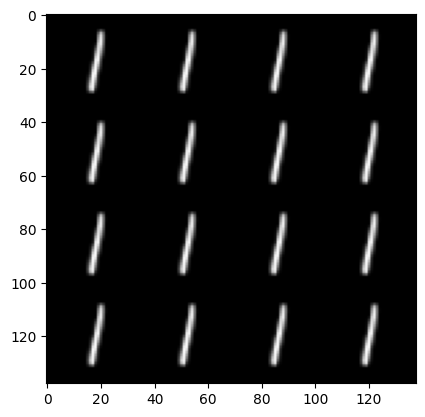

In [22]:
diffusor.posterior_variance_beta_hat *= 0
diffusor.posterior_variance_beta_sqrt *= 0
grid = make_grid(diffusor.p_sample_loop(model, 16, step_size=1), nrow=4)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

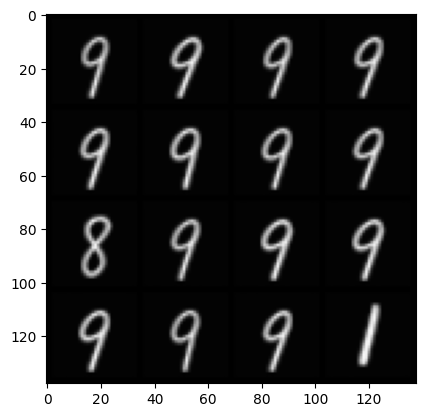

In [23]:
diffusor.posterior_variance_beta_hat *= 0
diffusor.posterior_variance_beta_sqrt *= 0
grid = make_grid(diffusor.p_sample_loop(model, 16, step_size=2), nrow=4)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


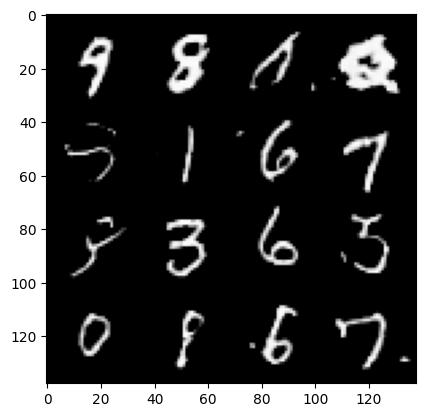

In [24]:
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

scheduler = DDIMScheduler(
    1000,
    beta_start=CFG.beta_start,
    beta_end=CFG.beta_end,
    beta_schedule="squaredcos_cap_v2",
)
scheduler.set_timesteps(1000)

img = torch.randn(16, 1, CFG.image_size, CFG.image_size, device=fabric.device)

with torch.no_grad():
    for t in reversed(range(1000)):
        img = scheduler.step(
            model_output=model(
                img,
                torch.tensor([t], device=fabric.device, dtype=torch.long),
            ),
            timestep=t,
            sample=img,
        ).prev_sample

grid = make_grid(img, nrow=4)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


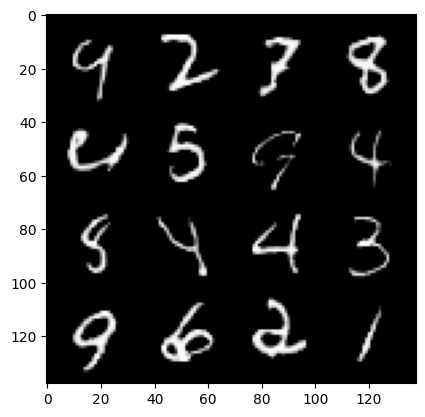

In [25]:
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

scheduler = DDIMScheduler(
    1000,
    beta_start=CFG.beta_start,
    beta_end=CFG.beta_end,
    beta_schedule="squaredcos_cap_v2",
)
scheduler.set_timesteps(100)

img = torch.randn(16, 1, CFG.image_size, CFG.image_size, device=fabric.device)

with torch.no_grad():
    for t in reversed(range(0, 1000, 10)):
        img = scheduler.step(
            model_output=model(
                img,
                torch.tensor([t], device=fabric.device, dtype=torch.long),
            ),
            timestep=t,
            sample=img,
        ).prev_sample

grid = make_grid(img, nrow=4)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)

In [ ]:
from diffusers.training_utils 